Typically, the standard linear model $Y=\beta_0+\beta_1X_1+...+\beta_pX_p+\epsilon$ is fitted using the least squares method. However, there are alternative fitting procedures that can yield better prediction accuracy and model interpretability.

* **Prediction Accuracy:** If the true relationship between the response and the predictor is approximately linear, the least square estimates will have low bias. If the number of predictors ($p$) is much less than the number of observations ($n$) then the least square estimates tend to also have low variance, and will perform well on test observations. However, if $n$ is not much larger than p, then there can be a lot of variability in the least square fit.
* **Model Interpretability:** Many of the variables used in a multiple regression model may not be associated with the response. By removing these variables we can obtain a model that is easily interpreted. 

### Subset Selection  
Subset selection involves identifying a subset of $p$ predictors that we believe to be related to the response. When fit a model using the reduced subset.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_squared_error

from itertools import combinations,chain

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Best Subset Selection
To perform best subset selection, we perform a seperate least square regression for each possible combination of $p$ predictors, resulting in $2^p$ possible models, with the goal of identifying the one that is best.
This is usually broken up int two stages.
1. Let $M_0$ denote the null model, which contains no predictors. This model simple predicts the sample mean for each observation.
2. For $k=1,2,..p$:  
a. Fit all $(^p_k)$ models that contain exactly k predcitors.
b. Pick best amoung these models, and call it $M_k$. Here the best is defined as having the smallest RSS, or equivalently largest $R^2$
3. Select a single best model from among $M_0,...,M_p$ using cross validation prediction error, $C_p (AIC), BIC$ or adjusted $R^2$

#### Performing Best Subset Selection for Credit data set

In [3]:
credit = pd.read_csv('./Credit.csv')
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Unnamed: 0    400 non-null int64
Income        400 non-null float64
Limit         400 non-null int64
Rating        400 non-null int64
Cards         400 non-null int64
Age           400 non-null int64
Education     400 non-null int64
Gender        400 non-null object
Student       400 non-null object
Married       400 non-null object
Ethnicity     400 non-null object
Balance       400 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 31.3+ KB


In [4]:
credit.drop('Unnamed: 0',axis=1,inplace=True)
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [5]:
# Creating dummy variables for categorical data. For variables with two levels we can use pd.factorize()
credit['d_Gender']=pd.factorize(credit['Gender'])[0]
print ('d_Gender factors',pd.factorize(credit['Gender'])[1])

credit['d_Student']=pd.factorize(credit['Student'])[0]
print ('d_Gender factors',pd.factorize(credit['Student'])[1])

credit['d_Married']=pd.factorize(credit['Married'])[0]
print ('d_Gender factors',pd.factorize(credit['Married'])[1])

credit = pd.concat([credit,pd.get_dummies(credit['Ethnicity'],prefix='D')],axis=1)

d_Gender factors Index([' Male', 'Female'], dtype='object')
d_Gender factors Index(['No', 'Yes'], dtype='object')
d_Gender factors Index(['Yes', 'No'], dtype='object')


In [6]:
credit.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender',
       'Student', 'Married', 'Ethnicity', 'Balance', 'd_Gender', 'd_Student',
       'd_Married', 'D_African American', 'D_Asian', 'D_Caucasian'],
      dtype='object')

In [7]:
features = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender',
            'd_Student', 'd_Married', 'D_African American', 'D_Asian']
target = ['Balance']

In [8]:
# Select best subset for regressor using the cross validated R^2 score

regr = LinearRegression()
# For each of the models record the test score
r2_subset_scores =[]
# For each of the models record the number of predictors used
predictors = []
# record the best subset score for the number of predictors used
r2_best_subset =[]

for n in range(1,len(features)+1):
    best_subset_score = - np.Infinity
    # Create subsets with n features each
    for i,subset in enumerate(combinations(features,n)):
        
        X = credit[list(subset)]
        y = credit[target]
        # Calcuate CV score for each subset
        subset_score = cross_val_score(regr,X,y,scoring = 'r2',cv=3).mean()
        # Set the best subset score to the current score if it is better
        if subset_score > best_subset_score:
            best_subset_score = subset_score
            best_subset = subset
        # Store the subset score and the number of predictors used 
        r2_subset_scores.append(subset_score)
        predictors.append(n)
        
    r2_best_subset.append(best_subset_score)
    # Print best subset for each model size
    print (best_subset)

('Rating',)
('Income', 'Rating')
('Income', 'Rating', 'd_Student')
('Income', 'Limit', 'Cards', 'd_Student')
('Income', 'Limit', 'Cards', 'Age', 'd_Student')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'd_Student')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Student')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student', 'D_African American')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student', 'd_Married', 'D_African American')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student', 'd_Married', 'D_African American', 'D_Asian')


Text(0,0.5,'$R^2$')

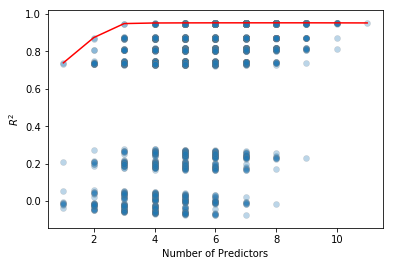

In [9]:
# Plot R^2 score for each of model 
plt.scatter(predictors,r2_subset_scores,alpha=0.3,edgecolors='gray',linewidths=0.5)
# Trace curve with the best r^2 for each model size (no. of predictors)
plt.plot(range(1,12),r2_best_subset,color ='r')
plt.xlabel('Number of Predictors')
plt.ylabel(r'$R^2$')

In [10]:
# Select best subset for regressor using the cross validated RSS score

regr = LinearRegression()
# For each of the models record the test score
mse_subset_scores =[]
# For each of the models record the number of predictors used
predictors = []
# record the best subset score for the number of predictors used
mse_best_subset =[]

for n in range(1,len(features)+1):
    best_subset_score = np.Infinity
    # Create subsets with n features each
    for i,subset in enumerate(combinations(features,n)):
        X = credit[list(subset)]
        y = credit[target]
    # Calcuate CV score for each subset    
        subset_score = -1*cross_val_score(regr,X,y,scoring = 'neg_mean_squared_error',cv=3).mean()
        
        if subset_score < best_subset_score:
            best_subset_score = subset_score
            best_subset = subset
    # Store the subset score and the number of predictors used    
        mse_subset_scores.append(subset_score)
        predictors.append(n)
        
    mse_best_subset.append(best_subset_score)
    # Print best subset for each model size
    print (best_subset)

('Rating',)
('Income', 'Rating')
('Income', 'Rating', 'd_Student')
('Income', 'Limit', 'Cards', 'd_Student')
('Income', 'Limit', 'Cards', 'Age', 'd_Student')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'd_Student')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Student')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student', 'D_African American')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student', 'd_Married', 'D_African American')
('Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student', 'd_Married', 'D_African American', 'D_Asian')


Text(0,0.5,'Mean Sum of Squares')

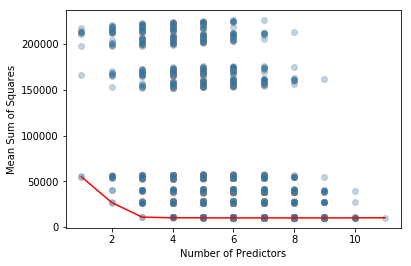

In [11]:
# Plot R^2 score for each of model 
plt.scatter(predictors,mse_subset_scores,alpha=0.3,edgecolors='gray',linewidths=1)
# Trace curve with the best r^2 for each model size (no. of predictors)
plt.plot(range(1,12),mse_best_subset,color ='r')
plt.xlabel('Number of Predictors')
plt.ylabel('Mean Sum of Squares')

As the number of predictors increase the model fit improves as well, however from three-variable model on, there is little improvement in RSS and $R^2$ as a result of including additional predictors.
While the best subset selection in simple and conceptually simple, it has computational limitations. When considering a dataset with $p$ predictors there are $2^p$ possible model with needs to be evaluated to identify the best subset. Consequently, best subset selection becomes computationally infeasible for values of $p$ greater than around 20.

In [12]:
features = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender',
            'd_Student', 'd_Married', 'D_African American', 'D_Asian']
target = ['Balance']

In [18]:
X = credit[['Income', 'Limit']]
y = credit[target]
    
print (features)
print (-1*cross_val_score(regr,X,y,scoring = 'r2',cv=3).mean())
    

['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student', 'd_Married', 'D_African American', 'D_Asian']
-0.8685620513846208


In [41]:
predictors = features
subset = []

    c_scores ={}
    for predictor in predictors:
        X = credit[predictor]
        y = credit[target]

        if isinstance(X,pd.DataFrame):
            c_scores[predictor] = cross_val_score(regr,X,y,scoring = 'neg_mean_squared_error',cv=3).mean()
        else:
            c_scores[predictor] = cross_val_score(regr,X.values.reshape(-1,1),y,scoring = 'neg_mean_squared_error',cv=3).mean()

    best_predictor = max(c_scores, key = c_scores.get)
    predictors.remove(predictor)
    subset.append(best_predictor)

In [46]:
predictors.remove('Rating')

In [34]:
c_scores

{'Age': 213629.95839441443,
 'Cards': 211425.5732209254,
 'D_African American': 212027.52950065513,
 'D_Asian': 213666.86929441823,
 'Education': 217962.53135197566,
 'Income': 166392.40705009957,
 'Limit': 55692.39592383532,
 'Rating': 54857.99588040213,
 'd_Gender': 212708.41520254573,
 'd_Married': 214351.38845272467,
 'd_Student': 198397.32943453}